
# Fader Network - Démonstration

Ce notebook permet de reproduire l'intégralité du code et des expériences décrites dans le dépôt **Fader Network**.
Vous trouverez :
1. Les dépendances
2. Les tests des "deux" modèles
3. La visualisation des courbes d'entrainement

---


In [28]:

# Importation des bibliothèques nécessaires
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os


## Test du modèle
Test du modèle entrainé seulement sur l'attribut lié au sexe.


/var/folders/91/87ycl4qx4wj7_tcybrtgzk840000gn/T/ipykernel_2467/1213533499.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load("sexe/t

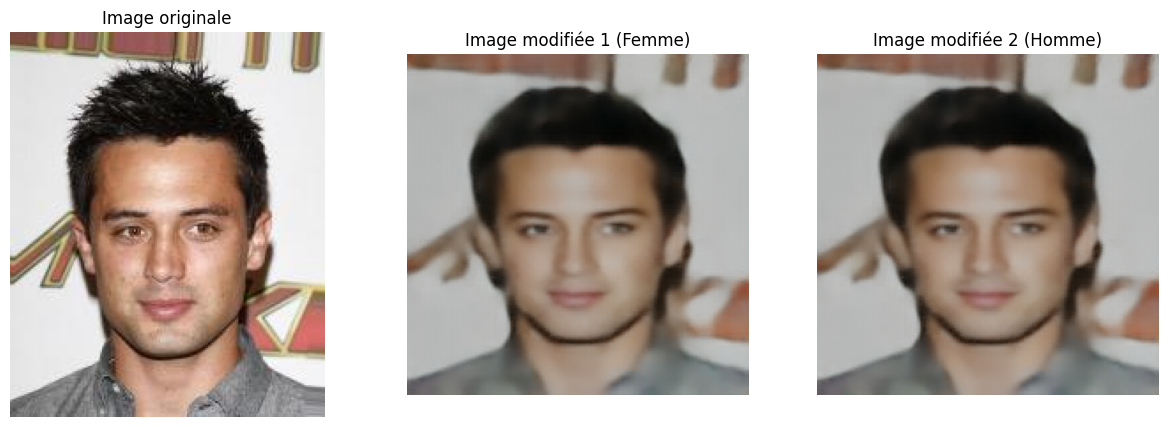

In [29]:
from sexe.model import AutoEncoder, Discriminator, CelebADataset

# CONFIG
image_name = "000007.jpg"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = AutoEncoder().to(device)
autoencoder.load_state_dict(torch.load("sexe/train_sexe70epoch/autoencoder.pth", map_location=device))
autoencoder.eval()

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
img_path = "datas/img_align_celeba/img_align_celeba/" + image_name
pil_img = Image.open(img_path).convert("RGB")
input_tensor = transform(pil_img).unsqueeze(0).to(device)

original_attrs = pd.read_csv("datas/list_attr_celeba.csv", sep=",", header=0, index_col="image_id").replace(-1, 0)
original_attrs = torch.from_numpy(original_attrs.loc[image_name].values.astype("float32"))
original_attrs = original_attrs.unsqueeze(0)
modified_attr = original_attrs.clone()
modified_attrs_1 = 1 - modified_attr[0][20]
modified_attrs_2 = modified_attr[0][20]

modified_attrs_1 = modified_attrs_1.unsqueeze(0)
modified_attrs_2 = modified_attrs_2.unsqueeze(0)

modified_attrs_1 = modified_attrs_1.to(device)
modified_attrs_2 = modified_attrs_2.to(device)

with torch.no_grad():
    z = autoencoder.encoder(input_tensor)
    output_tensor = autoencoder.decoder(z, modified_attrs_1)  # Femme
    output_tensor_2 = autoencoder.decoder(z, modified_attrs_2)  # Homme

output_image = output_tensor.squeeze(0).cpu().permute(1, 2, 0)
output_image_2 = output_tensor_2.squeeze(0).cpu().permute(1, 2, 0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Originale
axes[0].imshow(pil_img)
axes[0].axis('off')
axes[0].set_title("Image originale")

# Femme
axes[1].imshow(output_image.numpy())
axes[1].axis('off')
axes[1].set_title("Image modifiée 1 (Femme)")

# Homme
axes[2].imshow(output_image_2.numpy())
axes[2].axis('off')
axes[2].set_title("Image modifiée 2 (Homme)")

plt.show()


## Chargement des modèles
Nous chargeons l'autoencodeur et le discriminateur avec leurs poids sauvegardés.


/var/folders/91/87ycl4qx4wj7_tcybrtgzk840000gn/T/ipykernel_2467/3428765041.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load("allatt

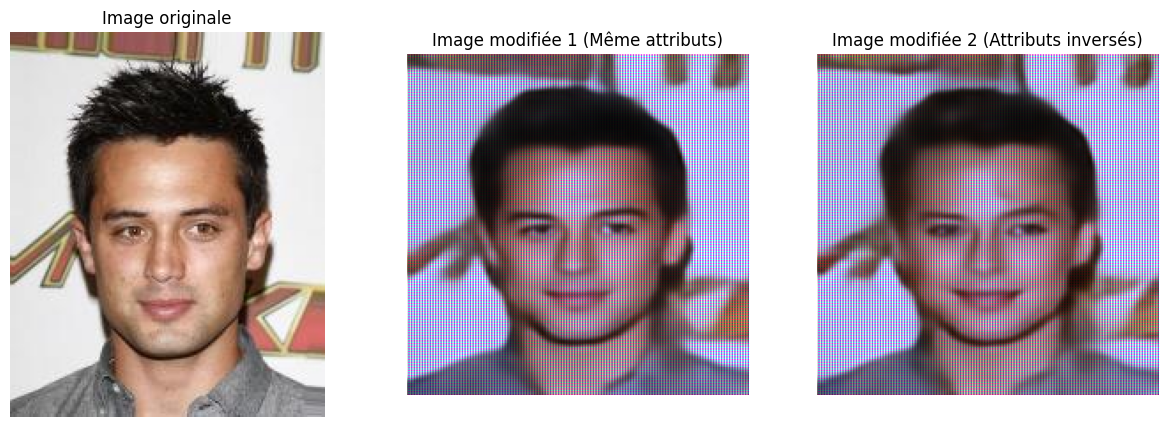

In [30]:
from allattributs.model import AutoEncoder, Discriminator, CelebADataset

# CONFIG
image_name = "000007.jpg"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = AutoEncoder().to(device)
autoencoder.load_state_dict(torch.load("allattributs/auto_good_res.pth", map_location=device))
autoencoder.eval()

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
img_path = "datas/img_align_celeba/img_align_celeba/" + image_name
pil_img = Image.open(img_path).convert("RGB")
input_tensor = transform(pil_img).unsqueeze(0).to(device)

original_attrs = pd.read_csv("datas/list_attr_celeba.csv", sep=",", header=0, index_col="image_id").replace(-1, 0)
original_attrs = torch.from_numpy(original_attrs.loc[image_name].values.astype("float32"))
original_attrs = original_attrs.unsqueeze(0)
modified_attr = original_attrs.clone()
modified_attrs_1 = modified_attr
modified_attrs_2 = 1-modified_attr

modified_attrs_1 = modified_attrs_1.unsqueeze(0)
modified_attrs_2 = modified_attrs_2.unsqueeze(0)

modified_attrs_1 = modified_attrs_1.to(device)
modified_attrs_2 = modified_attrs_2.to(device)

with torch.no_grad():
    z = autoencoder.encoder(input_tensor)
    output_tensor = autoencoder.decoder(z, modified_attrs_1)  # Same attributes
    output_tensor_2 = autoencoder.decoder(z, modified_attrs_2)  # Inverse

output_image = output_tensor.squeeze(0).cpu().permute(1, 2, 0)
output_image_2 = output_tensor_2.squeeze(0).cpu().permute(1, 2, 0)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Originale
axes[0].imshow(pil_img)
axes[0].axis('off')
axes[0].set_title("Image originale")

# Femme
axes[1].imshow(output_image.numpy())
axes[1].axis('off')
axes[1].set_title("Image modifiée 1 (Même attributs)")

# Homme
axes[2].imshow(output_image_2.numpy())
axes[2].axis('off')
axes[2].set_title("Image modifiée 2 (Attributs inversés)")

plt.show()

## Visualisation des courbes de perte pour 70 époques

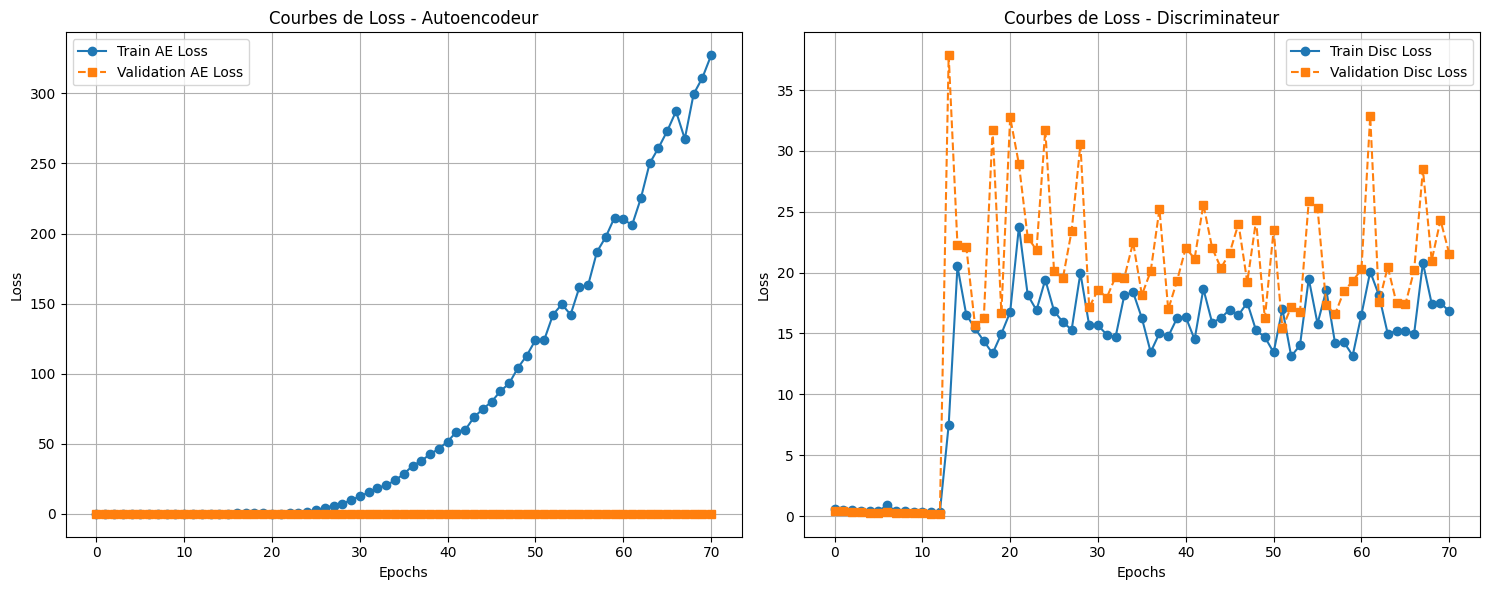

In [32]:
import matplotlib.pyplot as plt

def read_losses(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return [float(line.strip()) for line in lines]

# Chemins vers les fichiers
train_ae_loss_file = "sexe/train_sexe70epoch/vect_train_ae_loss.txt"
train_disc_loss_file = "sexe/train_sexe70epoch/vect_train_disc_loss.txt"
val_ae_loss_file = "sexe/train_sexe70epoch/vect_val_ae_loss.txt"
val_disc_loss_file = "sexe/train_sexe70epoch/vect_val_disc_loss.txt"

# Lecture des pertes
train_ae_loss = read_losses(train_ae_loss_file)
train_disc_loss = read_losses(train_disc_loss_file)
val_ae_loss = read_losses(val_ae_loss_file)
val_disc_loss = read_losses(val_disc_loss_file)

# Créer une figure avec deux sous-graphiques
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Tracer les courbes pour l'autoencodeur
axes[0].plot(train_ae_loss, label='Train AE Loss', linestyle='-', marker='o')
axes[0].plot(val_ae_loss, label='Validation AE Loss', linestyle='--', marker='s')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Courbes de Loss - Autoencodeur')
axes[0].legend()
axes[0].grid(True)

# Tracer les courbes pour le discriminateur
axes[1].plot(train_disc_loss, label='Train Disc Loss', linestyle='-', marker='o')
axes[1].plot(val_disc_loss, label='Validation Disc Loss', linestyle='--', marker='s')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Courbes de Loss - Discriminateur')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## De même pour 20 époques

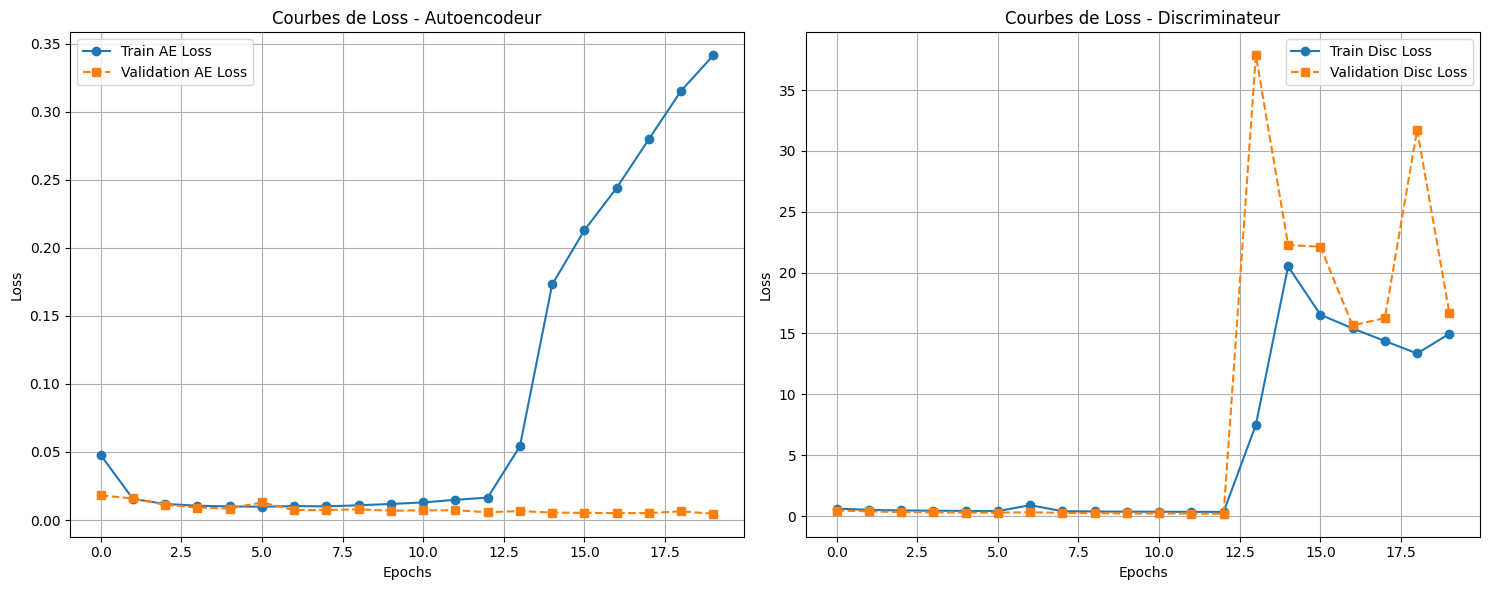

In [33]:
import matplotlib.pyplot as plt

def read_losses(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    return [float(line.strip()) for line in lines]

# Chemins vers les fichiers
train_ae_loss_file = "sexe/train_sexe20epoch/vect_train_ae_loss.txt"
train_disc_loss_file = "sexe/train_sexe20epoch/vect_train_disc_loss.txt"
val_ae_loss_file = "sexe/train_sexe20epoch/vect_val_ae_loss.txt"
val_disc_loss_file = "sexe/train_sexe20epoch/vect_val_disc_loss.txt"

# Lecture des pertes
train_ae_loss = read_losses(train_ae_loss_file)
train_disc_loss = read_losses(train_disc_loss_file)
val_ae_loss = read_losses(val_ae_loss_file)
val_disc_loss = read_losses(val_disc_loss_file)

# Créer une figure avec deux sous-graphiques
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Tracer les courbes pour l'autoencodeur
axes[0].plot(train_ae_loss, label='Train AE Loss', linestyle='-', marker='o')
axes[0].plot(val_ae_loss, label='Validation AE Loss', linestyle='--', marker='s')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Courbes de Loss - Autoencodeur')
axes[0].legend()
axes[0].grid(True)

# Tracer les courbes pour le discriminateur
axes[1].plot(train_disc_loss, label='Train Disc Loss', linestyle='-', marker='o')
axes[1].plot(val_disc_loss, label='Validation Disc Loss', linestyle='--', marker='s')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Courbes de Loss - Discriminateur')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()